In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import string
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from tqdm import tqdm
!pip install adabelief-pytorch==0.2.0
from adabelief_pytorch import AdaBelief
from torch.optim import *
import math
from sklearn.metrics import f1_score

In [2]:
# import os
# os.listdir('../input/emnist')
# os.listdir('data/EMNIST/processed/')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.5), (0.5))])
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5), (0.5))])

train_set = torchvision.datasets.EMNIST(root='./data', train=True, download=True, transform=transform, split='bymerge')
test_set = torchvision.datasets.EMNIST(root='./data', train=False, download=False, transform=transform, split='bymerge')

cuda:0


In [4]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=62):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        x = x.squeeze(1)
        return x

In [5]:
def evaluate(model, valid_dl):

  # we don't want to add evaluation related computation to computation graph
  with torch.no_grad():
    criterion = nn.CrossEntropyLoss()
    valid_loss_lst = torch.tensor([]).to('cuda')
    y_true_lst = torch.tensor([]).to('cuda')
    y_pred_lst = torch.tensor([]).to('cuda')
    
    for X_valid, y_valid in valid_dl:
      X_valid = X_valid.to('cuda')
      y_valid = y_valid.to('cuda')
      pred = model(X_valid)
      valid_loss_lst = torch.cat((valid_loss_lst, criterion(pred, y_valid).view(-1)))
      predicted = pred.argmax(1).squeeze()
      y_pred_lst = torch.cat((y_pred_lst, predicted))
      y_true_lst = torch.cat((y_true_lst, y_valid))

  return valid_loss_lst.mean().item(), f1_score(y_pred=y_pred_lst.to('cpu'), y_true=y_true_lst.to('cpu'), average='micro')


def train_res(**params):

  # define model and move it to gpu
  model = params['model']
  model.to('cuda')

  # define optimizer
  opt = params['optimizer'][0](model.parameters(), **params['optimizer'][1])

  # define data loader
  
  train_dl = DataLoader(params['train_data'], batch_size=params['batch_size'])
  valid_dl = DataLoader(params['test_data'], batch_size=params['batch_size'])

  # define loss
  criterion = torch.nn.CrossEntropyLoss()

  # start training
  valid_loss_lst = []
  train_loss_lst = []
  train_f1_lst = []
  valid_f1_lst = []

  for e in tqdm(range(params['epochs'] + 1)):
    train_losses = torch.tensor([]).to('cuda')
    correct = 0
    y_true_lst = torch.tensor([]).to('cuda')
    y_pred_lst = torch.tensor([]).to('cuda')
    
    for X_train, y_train in train_dl:

      X_train = X_train.to('cuda')
      y_train = y_train.to('cuda')
        
      pred = model(X_train)
      loss = criterion(pred, y_train)

      # perform backward propagation
      loss.backward()

      # update model parameters and clear up gradient after update
      opt.step()
      opt.zero_grad()
      train_losses = torch.cat((train_losses, loss.view(-1)))

      with torch.no_grad():
        predicted = pred.argmax(1).squeeze()
        y_pred_lst = torch.cat((y_pred_lst, predicted))
        y_true_lst = torch.cat((y_true_lst, y_train))
      
        
    valid_loss, valid_f1 = evaluate(model, valid_dl)
    train_loss = train_losses.mean().item()
    train_f1 = f1_score(y_pred=y_pred_lst.to('cpu'), y_true=y_true_lst.to('cpu'), average='micro')
    train_loss_lst.append(train_loss)
    valid_loss_lst.append(valid_loss)
    train_f1_lst.append(train_f1)
    valid_f1_lst.append(valid_f1)
    

    print(f'epoch: {e}, training loss: {train_loss}, training f1: {train_f1}, validation loss: {valid_loss}, validation f1: {valid_f1}')

  return model, train_loss_lst, valid_loss_lst, train_f1_lst, valid_f1_lst



In [6]:
class Padam(Optimizer):
    """Implements Partially adaptive momentum estimation (Padam) algorithm.
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-1)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        partial (float, optional): partially adaptive parameter
    """

    def __init__(self, params, lr=1e-1, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=True, partial = 1/4):
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad, partial = partial)
        super(Padam, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']
                partial = group['partial']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom**(partial*2))
                
        return loss



In [7]:
my_AlexNet_adam = AlexNet()
my_AlexNet_adam_belief = AlexNet()
my_AlexNet_padam = AlexNet()
my_AlexNet_SGD = AlexNet()

# Momentum

In [8]:
params = {
    'optimizer': (torch.optim.SGD, {'lr': 0.0005, 'momentum': 0.9}),
    'model': my_AlexNet_SGD,
    'epochs': 30,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
    
}
model_SGD, train_loss_lst_SGD, valid_loss_lst_SGD, train_f1_lst_SGD, valid_f1_lst_SGD = train_res(**params)

  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

epoch: 0, training loss: 1.132714867591858, training f1: 0.6738908661588808, validation loss: 0.42071184515953064, validation f1: 0.8518693637543735


  3%|██▌                                                                           | 1/31 [20:09<10:04:46, 1209.56s/it]

epoch: 1, training loss: 0.37070339918136597, training f1: 0.8697623837279276, validation loss: 0.34901708364486694, validation f1: 0.8759660600225234


  6%|█████                                                                          | 2/31 [39:38<9:38:42, 1197.34s/it]

epoch: 2, training loss: 0.3243200480937958, training f1: 0.883192058825215, validation loss: 0.31919124722480774, validation f1: 0.8850270367855024


 10%|███████▋                                                                       | 3/31 [50:55<8:05:58, 1041.38s/it]

epoch: 3, training loss: 0.30242449045181274, training f1: 0.8896955577334181, validation loss: 0.3018949329853058, validation f1: 0.8901936848258728


 13%|██████████                                                                    | 4/31 [1:02:27<7:01:25, 936.49s/it]

epoch: 4, training loss: 0.28738346695899963, training f1: 0.8939524194334119, validation loss: 0.2950192391872406, validation f1: 0.8921021638025154


 16%|████████████▌                                                                 | 5/31 [1:14:32<6:18:17, 872.98s/it]

epoch: 5, training loss: 0.278531014919281, training f1: 0.8967879392261712, validation loss: 0.2837821841239929, validation f1: 0.8953431393619491


 19%|███████████████                                                               | 6/31 [1:26:28<5:44:05, 825.81s/it]

epoch: 6, training loss: 0.27045950293540955, training f1: 0.8986462864577065, validation loss: 0.27775898575782776, validation f1: 0.8968303774833867


 23%|█████████████████▌                                                            | 7/31 [1:38:18<5:16:31, 791.30s/it]

epoch: 7, training loss: 0.2635525166988373, training f1: 0.9009043861006516, validation loss: 0.2762415111064911, validation f1: 0.897561101415885


 26%|████████████████████▏                                                         | 8/31 [1:49:29<4:49:24, 754.96s/it]

epoch: 8, training loss: 0.2584759593009949, training f1: 0.9026294825283838, validation loss: 0.27079713344573975, validation f1: 0.899332032358175


 29%|██████████████████████▋                                                       | 9/31 [2:00:36<4:27:12, 728.74s/it]

epoch: 9, training loss: 0.2539941370487213, training f1: 0.903682593719732, validation loss: 0.2688591182231903, validation f1: 0.9000025790256441


 32%|████████████████████████▊                                                    | 10/31 [2:11:40<4:08:12, 709.16s/it]

epoch: 10, training loss: 0.24977971613407135, training f1: 0.9046927207808211, validation loss: 0.266679048538208, validation f1: 0.9013436723605822


 35%|███████████████████████████▎                                                 | 11/31 [2:22:54<3:52:51, 698.60s/it]

epoch: 11, training loss: 0.24578654766082764, training f1: 0.90599370712333, validation loss: 0.26369380950927734, validation f1: 0.9009138347532304


 39%|█████████████████████████████▊                                               | 12/31 [2:34:05<3:38:41, 690.59s/it]

epoch: 12, training loss: 0.24266907572746277, training f1: 0.9068619865545641, validation loss: 0.2637438476085663, validation f1: 0.9013694626170233


 42%|████████████████████████████████▎                                            | 13/31 [2:45:22<3:25:53, 686.32s/it]

epoch: 13, training loss: 0.24014635384082794, training f1: 0.9077302659857981, validation loss: 0.2612013518810272, validation f1: 0.9018938644979927


 45%|██████████████████████████████████▊                                          | 14/31 [2:56:29<3:12:51, 680.68s/it]

epoch: 14, training loss: 0.237396240234375, training f1: 0.9086214702865035, validation loss: 0.26017582416534424, validation f1: 0.9019368482587279


 48%|█████████████████████████████████████▎                                       | 15/31 [3:07:37<3:00:28, 676.80s/it]

epoch: 15, training loss: 0.23416103422641754, training f1: 0.9097920714338933, validation loss: 0.25905781984329224, validation f1: 0.9033295221065482


 52%|███████████████████████████████████████▋                                     | 16/31 [3:18:43<2:48:23, 673.54s/it]

epoch: 16, training loss: 0.2321631759405136, training f1: 0.9101918238453028, validation loss: 0.25887203216552734, validation f1: 0.9035014571494889


 55%|██████████████████████████████████████████▏                                  | 17/31 [3:29:51<2:36:45, 671.81s/it]

epoch: 17, training loss: 0.2295340895652771, training f1: 0.9106460228217076, validation loss: 0.2590058445930481, validation f1: 0.9023580891139328


 58%|████████████████████████████████████████████▋                                | 18/31 [3:40:58<2:25:15, 670.45s/it]

epoch: 18, training loss: 0.22782555222511292, training f1: 0.9112606958844128, validation loss: 0.25774532556533813, validation f1: 0.9032693448415189


 61%|███████████████████████████████████████████████▏                             | 19/31 [3:52:10<2:14:10, 670.85s/it]

epoch: 19, training loss: 0.22481346130371094, training f1: 0.9122822853802376, validation loss: 0.25939348340034485, validation f1: 0.9028137169777258


 65%|█████████████████████████████████████████████████▋                           | 20/31 [4:03:21<2:03:00, 670.99s/it]

epoch: 20, training loss: 0.2229962795972824, training f1: 0.9127364843566422, validation loss: 0.2586685121059418, validation f1: 0.9033896993715774


 68%|████████████████████████████████████████████████████▏                        | 21/31 [4:14:37<1:52:04, 672.42s/it]

epoch: 21, training loss: 0.2209833860397339, training f1: 0.9130660293552953, validation loss: 0.25912922620773315, validation f1: 0.90306302278999


 71%|██████████████████████████████████████████████████████▋                      | 22/31 [4:25:52<1:40:59, 673.33s/it]

epoch: 22, training loss: 0.21938446164131165, training f1: 0.91361479341827, validation loss: 0.2572762966156006, validation f1: 0.9044986803985454


 74%|█████████████████████████████████████████████████████████▏                   | 23/31 [4:37:02<1:29:37, 672.16s/it]

epoch: 23, training loss: 0.21722806990146637, training f1: 0.9142337648940011, validation loss: 0.259147971868515, validation f1: 0.9037163759531649


 77%|███████████████████████████████████████████████████████████▌                 | 24/31 [4:48:11<1:18:19, 671.38s/it]

epoch: 24, training loss: 0.21541765332221985, training f1: 0.9146722030226441, validation loss: 0.25918883085250854, validation f1: 0.9035358441580771


 81%|██████████████████████████████████████████████████████████████               | 25/31 [4:59:15<1:06:54, 669.13s/it]

epoch: 25, training loss: 0.21378910541534424, training f1: 0.9152181014769347, validation loss: 0.25872400403022766, validation f1: 0.9044213096292221


 84%|██████████████████████████████████████████████████████████████████▎            | 26/31 [5:10:24<55:45, 669.11s/it]

epoch: 26, training loss: 0.21178379654884338, training f1: 0.9158155808875363, validation loss: 0.25731024146080017, validation f1: 0.9039226980046938


 87%|████████████████████████████████████████████████████████████████████▊          | 27/31 [5:21:34<44:37, 669.28s/it]

epoch: 27, training loss: 0.20976515114307404, training f1: 0.9164202243198478, validation loss: 0.2596578896045685, validation f1: 0.9033037318501071


 90%|███████████████████████████████████████████████████████████████████████▎       | 28/31 [5:32:50<33:33, 671.25s/it]

epoch: 28, training loss: 0.20828592777252197, training f1: 0.9165305502541795, validation loss: 0.259276807308197, validation f1: 0.9038883109961057


 94%|█████████████████████████████████████████████████████████████████████████▉     | 29/31 [5:43:56<22:19, 669.86s/it]

epoch: 29, training loss: 0.20666196942329407, training f1: 0.9172054010992475, validation loss: 0.2628462612628937, validation f1: 0.9039484882611349


 97%|████████████████████████████████████████████████████████████████████████████▍  | 30/31 [5:55:46<11:21, 681.90s/it]

epoch: 30, training loss: 0.20526474714279175, training f1: 0.9175077228154033, validation loss: 0.26118171215057373, validation f1: 0.903510053901636


100%|███████████████████████████████████████████████████████████████████████████████| 31/31 [6:07:45<00:00, 711.77s/it]


In [8]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd

In [10]:

sgd_df = pd.DataFrame(data={'train_loss': train_loss_lst_SGD, 
                            'valid_loss': valid_loss_lst_SGD, 
                            'train_f1': train_f1_lst_SGD, 
                            'valid_f1': valid_f1_lst_SGD, 
                            'category': ['sgd']*len(train_loss_lst_SGD)})

sgd_df.to_parquet('./sgd_results30.parquet')

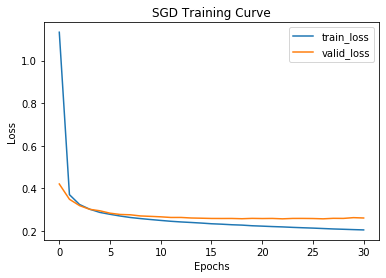

In [11]:
epo=[i for i in range(31)]
plt.title("SGD Training Curve")
plt.plot(epo, train_loss_lst_SGD, label="train_loss")
plt.plot(epo, valid_loss_lst_SGD, label="valid_loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

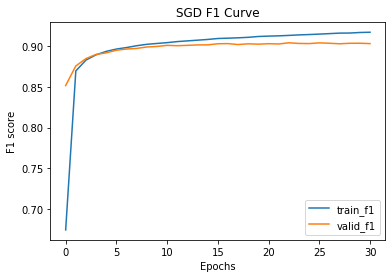

In [12]:
plt.title("SGD F1 Curve")
plt.plot(epo, train_f1_lst_SGD, label="train_f1")
plt.plot(epo, valid_f1_lst_SGD, label="valid_f1")

plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()

## ADAM

In [13]:
params = {
    'optimizer': (torch.optim.Adam, {'lr': 0.0005}),
    'model': my_AlexNet_adam,
    'epochs': 30,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
    
}
model, train_loss_lst, valid_loss_lst, train_f1_lst, valid_f1_lst = train_res(**params)

  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

epoch: 0, training loss: 0.4061153531074524, training f1: 0.8612042433933391, validation loss: 0.32392480969429016, validation f1: 0.886247775590382


  3%|██▌                                                                             | 1/31 [13:23<6:41:34, 803.14s/it]

epoch: 1, training loss: 0.29794803261756897, training f1: 0.8921857716797625, validation loss: 0.3134179413318634, validation f1: 0.8893941868761982


  6%|█████▏                                                                          | 2/31 [30:15<6:58:33, 866.00s/it]

epoch: 2, training loss: 0.28541091084480286, training f1: 0.895294957101838, validation loss: 0.296709269285202, validation f1: 0.8930821935472778


 10%|███████▋                                                                        | 3/31 [48:48<7:18:39, 939.98s/it]

epoch: 3, training loss: 0.2795439660549164, training f1: 0.8969999942687826, validation loss: 0.29482924938201904, validation f1: 0.8925577916663084


 13%|██████████                                                                    | 4/31 [1:06:11<7:16:53, 970.87s/it]

epoch: 4, training loss: 0.27622371912002563, training f1: 0.8978596768739648, validation loss: 0.2886165976524353, validation f1: 0.8952743653447728


 16%|████████████▍                                                                | 5/31 [1:24:50<7:19:55, 1015.21s/it]

epoch: 5, training loss: 0.27408862113952637, training f1: 0.8984657531106183, validation loss: 0.28871044516563416, validation f1: 0.8972000378257095


 19%|██████████████▉                                                              | 6/31 [1:43:46<7:18:07, 1051.51s/it]

epoch: 6, training loss: 0.27999061346054077, training f1: 0.8968509826172177, validation loss: 0.2961641848087311, validation f1: 0.8950164627803616


 23%|█████████████████▌                                                            | 7/31 [1:58:09<6:37:58, 994.95s/it]

epoch: 7, training loss: 0.2700625956058502, training f1: 0.89953605795407, validation loss: 0.2930513620376587, validation f1: 0.8946382056858919


 26%|████████████████████▏                                                         | 8/31 [2:12:32<6:06:16, 955.49s/it]

epoch: 8, training loss: 0.27821922302246094, training f1: 0.8977708430047625, validation loss: 0.3100370466709137, validation f1: 0.8888010109780525


 29%|██████████████████████▋                                                       | 9/31 [2:26:51<5:39:43, 926.53s/it]

epoch: 9, training loss: 0.27619439363479614, training f1: 0.8975917424620163, validation loss: 0.29199567437171936, validation f1: 0.8951798010711554


 32%|████████████████████████▊                                                    | 10/31 [2:41:10<5:17:09, 906.17s/it]

epoch: 10, training loss: 0.2750363051891327, training f1: 0.8982049827203796, validation loss: 0.3026454746723175, validation f1: 0.8943545128650396


 35%|███████████████████████████▎                                                 | 11/31 [2:55:31<4:57:33, 892.69s/it]

epoch: 11, training loss: 0.2716352939605713, training f1: 0.8987107626530951, validation loss: 0.29126062989234924, validation f1: 0.894225561582834


 39%|█████████████████████████████▊                                               | 12/31 [3:09:51<4:39:35, 882.90s/it]

epoch: 12, training loss: 0.27113768458366394, training f1: 0.8990832917820074, validation loss: 0.2844749391078949, validation f1: 0.8961168470551826


 42%|████████████████████████████████▎                                            | 13/31 [3:24:11<4:22:48, 876.03s/it]

epoch: 13, training loss: 0.2736309766769409, training f1: 0.8978897657651461, validation loss: 0.2958025634288788, validation f1: 0.8937441434625998


 45%|██████████████████████████████████▊                                          | 14/31 [3:38:33<4:07:01, 871.84s/it]

epoch: 14, training loss: 0.27141180634498596, training f1: 0.8988826991741315, validation loss: 0.2923218905925751, validation f1: 0.8947499634638034


 48%|█████████████████████████████████████▎                                       | 15/31 [3:52:58<3:51:57, 869.82s/it]

epoch: 15, training loss: 0.2732390761375427, training f1: 0.8982837869591881, validation loss: 0.2965216040611267, validation f1: 0.8953775263705374


 52%|███████████████████████████████████████▋                                     | 16/31 [4:07:21<3:36:57, 867.86s/it]

epoch: 16, training loss: 0.27310481667518616, training f1: 0.8984643203062762, validation loss: 0.29352307319641113, validation f1: 0.8942771420957163


 55%|██████████████████████████████████████████▏                                  | 17/31 [4:20:45<3:17:59, 848.55s/it]

epoch: 17, training loss: 0.2741898000240326, training f1: 0.897998658895136, validation loss: 0.29479628801345825, validation f1: 0.8967358132097694


 58%|████████████████████████████████████████████▋                                | 18/31 [4:32:40<2:55:10, 808.48s/it]

epoch: 18, training loss: 0.28534644842147827, training f1: 0.895154542276325, validation loss: 0.3021877110004425, validation f1: 0.8900991205522554


 61%|███████████████████████████████████████████████▏                             | 19/31 [4:43:49<2:33:18, 766.56s/it]

epoch: 19, training loss: 0.29561129212379456, training f1: 0.8933033590664993, validation loss: 0.3173770010471344, validation f1: 0.8868667417449687


 65%|█████████████████████████████████████████████████▋                           | 20/31 [4:54:14<2:12:47, 724.28s/it]

epoch: 20, training loss: 0.27982503175735474, training f1: 0.8961933254242533, validation loss: 0.2906481623649597, validation f1: 0.8948359309852738


 68%|████████████████████████████████████████████████████▏                        | 21/31 [5:04:38<1:55:40, 694.05s/it]

epoch: 21, training loss: 0.2744843065738678, training f1: 0.8979112578302757, validation loss: 0.28740212321281433, validation f1: 0.896202814576653


 71%|██████████████████████████████████████████████████████▋                      | 22/31 [5:14:52<1:40:30, 670.01s/it]

epoch: 22, training loss: 0.2840760350227356, training f1: 0.8956560237960145, validation loss: 0.3031165599822998, validation f1: 0.8935378214110709


 74%|█████████████████████████████████████████████████████████▏                   | 23/31 [5:24:48<1:26:22, 647.86s/it]

epoch: 23, training loss: 0.2741166949272156, training f1: 0.8980502398514467, validation loss: 0.30565667152404785, validation f1: 0.8919044385031335


 77%|███████████████████████████████████████████████████████████▌                 | 24/31 [5:34:42<1:13:41, 631.71s/it]

epoch: 24, training loss: 0.28181886672973633, training f1: 0.8961016259463672, validation loss: 0.3016333281993866, validation f1: 0.8935034344024827


 81%|██████████████████████████████████████████████████████████████               | 25/31 [5:45:29<1:03:37, 636.31s/it]

epoch: 25, training loss: 0.2718527019023895, training f1: 0.8988010293266393, validation loss: 0.29578059911727905, validation f1: 0.8931853545730423


 84%|████████████████████████████████████████████████████████████████▌            | 26/31 [6:03:42<1:04:26, 773.26s/it]

epoch: 26, training loss: 0.27538806200027466, training f1: 0.8976332937879334, validation loss: 0.2925652861595154, validation f1: 0.8967530067140634


 87%|████████████████████████████████████████████████████████████████████▊          | 27/31 [6:21:27<57:23, 860.83s/it]

epoch: 27, training loss: 0.2823813855648041, training f1: 0.8960615074247921, validation loss: 0.29031649231910706, validation f1: 0.8948015439766857


 90%|███████████████████████████████████████████████████████████████████████▎       | 28/31 [6:40:21<47:08, 942.86s/it]

epoch: 28, training loss: 0.2881283164024353, training f1: 0.8941487136282618, validation loss: 0.29689303040504456, validation f1: 0.8952227848318906


 94%|████████████████████████████████████████████████████████████████████████▉     | 29/31 [7:01:52<34:54, 1047.14s/it]

epoch: 29, training loss: 0.2735092043876648, training f1: 0.89809608959039, validation loss: 0.3044202923774719, validation f1: 0.8911737145706352


 97%|███████████████████████████████████████████████████████████████████████████▍  | 30/31 [7:19:26<17:29, 1049.29s/it]

epoch: 30, training loss: 0.2727169394493103, training f1: 0.8982551308723488, validation loss: 0.3000766336917877, validation f1: 0.8947757537202445


100%|███████████████████████████████████████████████████████████████████████████████| 31/31 [7:36:19<00:00, 883.21s/it]


In [14]:
adam_df = belif_df = pd.DataFrame(data={'train_loss': train_loss_lst, 
                            'valid_loss': valid_loss_lst, 
                            'train_f1': train_f1_lst, 
                            'valid_f1': valid_f1_lst, 
                            'category': ['adam']*len(train_loss_lst_SGD)})

adam_df.to_parquet('./adam_results30.parquet')

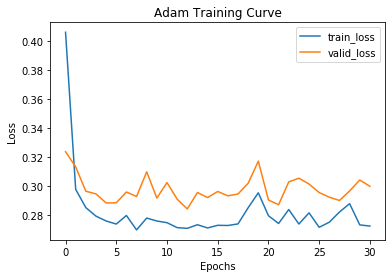

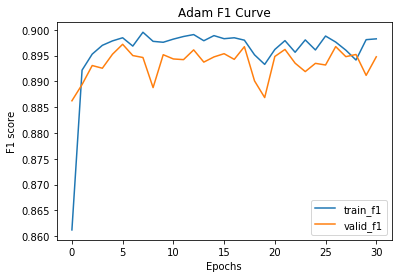

In [15]:

plt.title("Adam Training Curve")
plt.plot(epo, train_loss_lst, label="train_loss")
plt.plot(epo, valid_loss_lst, label="valid_loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.title("Adam F1 Curve")
plt.plot(epo, train_f1_lst, label="train_f1")
plt.plot(epo, valid_f1_lst, label="valid_f1")

plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()

# AdaBelif

In [16]:
params = {
    'optimizer': (AdaBelief, {'lr': 0.0005}),
    'model': my_AlexNet_adam_belief,
    'epochs': 30,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
    
}

model_belief, train_loss_lst_belief, valid_loss_lst_belief, train_f1_lst_belief, valid_f1_lst_belief = train_res(**params)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

epoch: 0, training loss: 0.4001612961292267, training f1: 0.863235959950253, validation loss: 0.3275742828845978, validation f1: 0.8868237579842336


  3%|██▌                                                                           | 1/31 [21:06<10:33:13, 1266.47s/it]

epoch: 1, training loss: 0.298002153635025, training f1: 0.8922373526360735, validation loss: 0.29393792152404785, validation f1: 0.8938644979926583


  6%|█████                                                                         | 2/31 [41:42<10:07:41, 1257.31s/it]

epoch: 2, training loss: 0.2858680188655853, training f1: 0.8957405592521908, validation loss: 0.30036014318466187, validation f1: 0.8914746008957816


 10%|███████▍                                                                     | 3/31 [1:02:36<9:46:17, 1256.33s/it]

epoch: 3, training loss: 0.27987024188041687, training f1: 0.8969870990297049, validation loss: 0.29363715648651123, validation f1: 0.8942599485914222


 13%|█████████▉                                                                   | 4/31 [1:27:21<9:56:16, 1325.05s/it]

epoch: 4, training loss: 0.2779039144515991, training f1: 0.8976691138964827, validation loss: 0.3010907471179962, validation f1: 0.8932197415816304


 16%|████████████▎                                                               | 5/31 [2:00:34<11:00:55, 1525.20s/it]

epoch: 5, training loss: 0.27291980385780334, training f1: 0.8986033023274473, validation loss: 0.28540071845054626, validation f1: 0.8971828443214154


 19%|██████████████▋                                                             | 6/31 [2:30:41<11:10:48, 1609.92s/it]

epoch: 6, training loss: 0.2711044251918793, training f1: 0.899341196563562, validation loss: 0.2938792109489441, validation f1: 0.8958761379950655


 23%|█████████████████▏                                                          | 7/31 [3:04:40<11:35:27, 1738.66s/it]

epoch: 7, training loss: 0.26997727155685425, training f1: 0.89973235214892, validation loss: 0.29003480076789856, validation f1: 0.895987895772977


 26%|███████████████████▊                                                         | 8/31 [3:23:06<9:53:45, 1548.94s/it]

epoch: 8, training loss: 0.27309826016426086, training f1: 0.8989829954780695, validation loss: 0.2943669259548187, validation f1: 0.8952485750883317


 29%|██████████████████████▎                                                      | 9/31 [3:33:58<7:49:12, 1279.65s/it]

epoch: 9, training loss: 0.27368754148483276, training f1: 0.8987494483703283, validation loss: 0.29591086506843567, validation f1: 0.8955494614134781


 32%|████████████████████████▌                                                   | 10/31 [3:44:44<6:21:19, 1089.50s/it]

epoch: 10, training loss: 0.269724577665329, training f1: 0.8996377870623499, validation loss: 0.2946782410144806, validation f1: 0.8962715885938293


 35%|██████████████████████████▉                                                 | 11/31 [4:00:15<5:47:22, 1042.12s/it]

epoch: 11, training loss: 0.2688201367855072, training f1: 0.9000490019084953, validation loss: 0.2885308861732483, validation f1: 0.8972258280821506


 39%|█████████████████████████████▍                                              | 12/31 [4:17:29<5:29:11, 1039.54s/it]

epoch: 12, training loss: 0.2641167640686035, training f1: 0.9013514210553464, validation loss: 0.28300657868385315, validation f1: 0.8966756359447401


 42%|████████████████████████████████▎                                            | 13/31 [4:28:13<4:36:16, 920.91s/it]

epoch: 13, training loss: 0.26358434557914734, training f1: 0.9013901067725796, validation loss: 0.2901988923549652, validation f1: 0.8972774085950328


 45%|██████████████████████████████████▊                                          | 14/31 [4:42:00<4:12:58, 892.84s/it]

epoch: 14, training loss: 0.2664217948913574, training f1: 0.9007109575144856, validation loss: 0.30343878269195557, validation f1: 0.8930735967951308


 48%|████████████████████████████████████▊                                       | 15/31 [5:08:38<4:54:31, 1104.45s/it]

epoch: 15, training loss: 0.2636428773403168, training f1: 0.9007625384707966, validation loss: 0.28806906938552856, validation f1: 0.8965037009017993


 52%|███████████████████████████████████████▏                                    | 16/31 [5:24:52<4:26:17, 1065.14s/it]

epoch: 16, training loss: 0.2622528374195099, training f1: 0.9017440094450462, validation loss: 0.2861238121986389, validation f1: 0.8987302597078825


 55%|█████████████████████████████████████████▋                                  | 17/31 [5:41:11<4:02:29, 1039.25s/it]

epoch: 17, training loss: 0.2602640986442566, training f1: 0.9022712814428913, validation loss: 0.29452386498451233, validation f1: 0.897561101415885


 58%|████████████████████████████████████████████▏                               | 18/31 [5:57:21<3:40:40, 1018.49s/it]

epoch: 18, training loss: 0.2620465159416199, training f1: 0.9015864009674295, validation loss: 0.29205551743507385, validation f1: 0.8965380879103875


 61%|███████████████████████████████████████████████▏                             | 19/31 [6:13:10<3:19:32, 997.71s/it]

epoch: 19, training loss: 0.260590136051178, training f1: 0.9023758761598552, validation loss: 0.2914407253265381, validation f1: 0.8985841149213827


 65%|█████████████████████████████████████████████████▋                           | 20/31 [6:28:45<2:59:29, 979.07s/it]

epoch: 20, training loss: 0.2609514594078064, training f1: 0.9021566570955336, validation loss: 0.2925288677215576, validation f1: 0.8939418687619818


 68%|████████████████████████████████████████████████████▏                        | 21/31 [6:43:49<2:39:23, 956.38s/it]

epoch: 21, training loss: 0.2864496409893036, training f1: 0.8985775118492918, validation loss: 0.3016515076160431, validation f1: 0.8973461826122091


 71%|██████████████████████████████████████████████████████▋                      | 22/31 [6:58:47<2:20:49, 938.85s/it]

epoch: 22, training loss: 0.2594587206840515, training f1: 0.9024561132030054, validation loss: 0.29094505310058594, validation f1: 0.8973461826122091


 74%|█████████████████████████████████████████████████████████▏                   | 23/31 [7:13:44<2:03:30, 926.27s/it]

epoch: 23, training loss: 0.2580999732017517, training f1: 0.9025048285506324, validation loss: 0.28446632623672485, validation f1: 0.8978963747496196


 77%|███████████████████████████████████████████████████████████▌                 | 24/31 [7:28:46<1:47:13, 919.12s/it]

epoch: 24, training loss: 0.25918254256248474, training f1: 0.9022684158342074, validation loss: 0.28988832235336304, validation f1: 0.8968045872269457


 81%|██████████████████████████████████████████████████████████████               | 25/31 [7:43:48<1:31:23, 913.87s/it]

epoch: 25, training loss: 0.2599557638168335, training f1: 0.9022655502255233, validation loss: 0.29265519976615906, validation f1: 0.8965294911582404


 84%|████████████████████████████████████████████████████████████████▌            | 26/31 [7:58:40<1:15:36, 907.40s/it]

epoch: 26, training loss: 0.2586035132408142, training f1: 0.9025005301376066, validation loss: 0.3310833275318146, validation f1: 0.8828348649880076


 87%|███████████████████████████████████████████████████████████████████          | 27/31 [8:13:39<1:00:19, 904.97s/it]

epoch: 27, training loss: 0.2593613266944885, training f1: 0.9023457872686738, validation loss: 0.2959364354610443, validation f1: 0.8949476887631853


 90%|███████████████████████████████████████████████████████████████████████▎       | 28/31 [8:28:48<45:18, 906.08s/it]

epoch: 28, training loss: 0.2608031928539276, training f1: 0.9022096708561865, validation loss: 0.3012162446975708, validation f1: 0.8942857388478633


 94%|█████████████████████████████████████████████████████████████████████████▉     | 29/31 [8:43:16<29:48, 894.49s/it]

epoch: 29, training loss: 0.2618403434753418, training f1: 0.9018586337924037, validation loss: 0.2986750602722168, validation f1: 0.893795723975482


 97%|████████████████████████████████████████████████████████████████████████████▍  | 30/31 [8:57:39<14:45, 885.15s/it]

epoch: 30, training loss: 0.26913899183273315, training f1: 0.8998942590395625, validation loss: 0.30282777547836304, validation f1: 0.8973031988514739


100%|██████████████████████████████████████████████████████████████████████████████| 31/31 [9:19:37<00:00, 1083.13s/it]


In [17]:
belif_df = pd.DataFrame(data={'train_loss': train_loss_lst_belief, 
                            'valid_loss': valid_loss_lst_belief, 
                            'train_f1': train_f1_lst_belief, 
                            'valid_f1': valid_f1_lst_belief, 
                            'category': ['belief']*len(train_loss_lst_SGD)})

belif_df.to_parquet('./belif_results30.parquet')

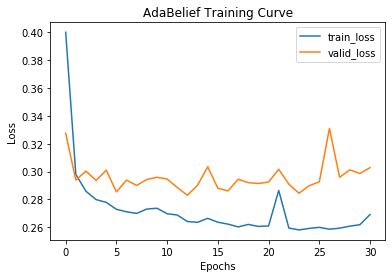

In [18]:

plt.title("AdaBelief Training Curve")
plt.plot(epo, train_loss_lst_belief, label="train_loss")
plt.plot(epo, valid_loss_lst_belief, label="valid_loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

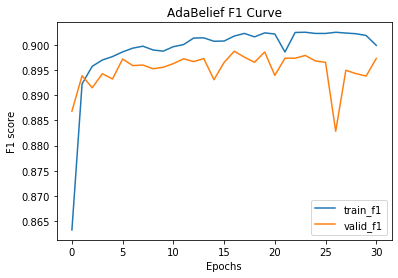

In [19]:
plt.title("AdaBelief F1 Curve")
plt.plot(epo, train_f1_lst_belief, label="train_f1")
plt.plot(epo, valid_f1_lst_belief, label="valid_f1")

plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()

# Padam

In [10]:
params = {
    'optimizer': (Padam, {'lr': 0.0005}),
    'model': my_AlexNet_padam,
    'epochs': 30,
    'batch_size': 64,
    'train_data': train_set,
    'test_data': test_set
    
}

model_padam, train_loss_lst_padam, valid_loss_lst_padam, train_f1_lst_padam, valid_f1_lst_padam = train_res(**params)

  0%|                                                                                           | 0/31 [00:00<?, ?it/s]E:\anapython\lib\site-packages\ipykernel_launcher.py:66: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)


epoch: 0, training loss: 0.6172420382499695, training f1: 0.8065370265298052, validation loss: 0.33431103825569153, validation f1: 0.8804449678911307


  3%|██▌                                                                            | 1/31 [19:23<9:41:59, 1163.98s/it]

epoch: 1, training loss: 0.3087542951107025, training f1: 0.8881825163482976, validation loss: 0.30081644654273987, validation f1: 0.8912338918356644


  6%|█████                                                                          | 2/31 [41:01<9:41:53, 1203.93s/it]

epoch: 2, training loss: 0.28094208240509033, training f1: 0.8963910524234454, validation loss: 0.28121814131736755, validation f1: 0.8966928294490342


 10%|███████▍                                                                     | 3/31 [1:01:42<9:27:07, 1215.26s/it]

epoch: 3, training loss: 0.2665923833847046, training f1: 0.899968764865345, validation loss: 0.2718161344528198, validation f1: 0.8991772908195284


 13%|█████████▉                                                                   | 4/31 [1:26:16<9:41:42, 1292.69s/it]

epoch: 4, training loss: 0.2565857768058777, training f1: 0.9033186614168716, validation loss: 0.2652779817581177, validation f1: 0.9006903191974073


 16%|████████████▍                                                                | 5/31 [1:47:30<9:17:50, 1287.32s/it]

epoch: 5, training loss: 0.24879679083824158, training f1: 0.905611148364024, validation loss: 0.2617247700691223, validation f1: 0.9016875424464638


 19%|██████████████▉                                                              | 6/31 [2:08:42<8:54:22, 1282.51s/it]

epoch: 6, training loss: 0.24283672869205475, training f1: 0.9069737452932377, validation loss: 0.25986531376838684, validation f1: 0.902633185182638


 23%|█████████████████▍                                                           | 7/31 [2:38:13<9:31:40, 1429.19s/it]

epoch: 7, training loss: 0.2372155338525772, training f1: 0.9087848099814881, validation loss: 0.2567729949951172, validation f1: 0.9036046181752534


 26%|███████████████████▌                                                        | 8/31 [3:20:53<11:17:53, 1768.41s/it]

epoch: 8, training loss: 0.23344247043132782, training f1: 0.9098135634990229, validation loss: 0.2556324005126953, validation f1: 0.9042063908255461


 29%|██████████████████████                                                      | 9/31 [3:46:33<10:23:15, 1699.80s/it]

epoch: 9, training loss: 0.2285114973783493, training f1: 0.911204816515076, validation loss: 0.2545293867588043, validation f1: 0.9043009550991635


 32%|████████████████████████▌                                                   | 10/31 [4:10:46<9:29:01, 1625.76s/it]

epoch: 10, training loss: 0.22503715753555298, training f1: 0.9119685012293461, validation loss: 0.2540809214115143, validation f1: 0.9045244706549865


 35%|██████████████████████████▉                                                 | 11/31 [4:26:56<7:56:22, 1429.13s/it]

epoch: 11, training loss: 0.22180524468421936, training f1: 0.9131405351810779, validation loss: 0.25386637449264526, validation f1: 0.9046878089457803


 39%|█████████████████████████████▍                                              | 12/31 [4:43:53<6:53:25, 1305.54s/it]

epoch: 12, training loss: 0.21801753342151642, training f1: 0.9140217098513895, validation loss: 0.25407612323760986, validation f1: 0.905280984843926


 42%|███████████████████████████████▊                                            | 13/31 [4:59:59<6:01:03, 1203.51s/it]

epoch: 13, training loss: 0.2147430032491684, training f1: 0.9149515998693283, validation loss: 0.2529950439929962, validation f1: 0.9051176465531322


 45%|██████████████████████████████████▎                                         | 14/31 [5:21:05<5:46:21, 1222.43s/it]

epoch: 14, training loss: 0.2118433564901352, training f1: 0.9158413713656918, validation loss: 0.2547963261604309, validation f1: 0.9059085477506598


 48%|████████████████████████████████████▊                                       | 15/31 [5:41:56<5:28:14, 1230.94s/it]

epoch: 15, training loss: 0.2086455523967743, training f1: 0.9165635047540448, validation loss: 0.25687333941459656, validation f1: 0.9047479862108095


 52%|███████████████████████████████████████▏                                    | 16/31 [6:12:35<5:53:20, 1413.34s/it]

epoch: 16, training loss: 0.2060883790254593, training f1: 0.9171996698818796, validation loss: 0.2563574016094208, validation f1: 0.9049457115101914


 55%|█████████████████████████████████████████▋                                  | 17/31 [6:31:38<5:10:52, 1332.29s/it]

epoch: 17, training loss: 0.20321427285671234, training f1: 0.918387464681373, validation loss: 0.25827494263648987, validation f1: 0.9045760511678688


 58%|████████████████████████████████████████████▏                               | 18/31 [6:46:21<4:19:27, 1197.51s/it]

epoch: 18, training loss: 0.20051448047161102, training f1: 0.91930159385155, validation loss: 0.2599906623363495, validation f1: 0.905728015955572


 61%|██████████████████████████████████████████████▌                             | 19/31 [6:59:31<3:35:03, 1075.26s/it]

epoch: 19, training loss: 0.19781003892421722, training f1: 0.9200437865006906, validation loss: 0.26008111238479614, validation f1: 0.9050918562966911


 65%|█████████████████████████████████████████████████▋                           | 20/31 [7:12:35<3:01:05, 987.80s/it]

epoch: 20, training loss: 0.1945841908454895, training f1: 0.9209077675188987, validation loss: 0.2635582983493805, validation f1: 0.9049027277494562


 68%|████████████████████████████████████████████████████▏                        | 21/31 [7:26:23<2:36:39, 939.95s/it]

epoch: 21, training loss: 0.1921812891960144, training f1: 0.9215453654510755, validation loss: 0.26378804445266724, validation f1: 0.9051520335617204


 71%|██████████████████████████████████████████████████████▋                      | 22/31 [7:42:02<2:20:56, 939.61s/it]

epoch: 22, training loss: 0.1895257830619812, training f1: 0.9224709570559882, validation loss: 0.2705799639225006, validation f1: 0.9033982961237245


 74%|█████████████████████████████████████████████████████████▏                   | 23/31 [7:52:11<1:52:02, 840.36s/it]

epoch: 23, training loss: 0.18697313964366913, training f1: 0.9229939306408075, validation loss: 0.2724285125732422, validation f1: 0.9033467156108422


 77%|███████████████████████████████████████████████████████████▌                 | 24/31 [8:02:05<1:29:24, 766.40s/it]

epoch: 24, training loss: 0.18469461798667908, training f1: 0.923685975137979, validation loss: 0.27572718262672424, validation f1: 0.9031489903114603


 81%|██████████████████████████████████████████████████████████████               | 25/31 [8:12:04<1:11:36, 716.14s/it]

epoch: 25, training loss: 0.18209265172481537, training f1: 0.9246617148948608, validation loss: 0.2770414650440216, validation f1: 0.9018594774894045


 84%|██████████████████████████████████████████████████████████████████▎            | 26/31 [8:23:51<59:26, 713.38s/it]

epoch: 26, training loss: 0.17974026501178741, training f1: 0.9254898758045197, validation loss: 0.2844686806201935, validation f1: 0.9025472176611677


 87%|████████████████████████████████████████████████████████████████████▊          | 27/31 [8:38:00<50:16, 754.21s/it]

epoch: 27, training loss: 0.17719119787216187, training f1: 0.9263624536487796, validation loss: 0.2821732461452484, validation f1: 0.9034756668930478


 90%|███████████████████████████████████████████████████████████████████████▎       | 28/31 [8:52:05<39:04, 781.35s/it]

epoch: 28, training loss: 0.17533093690872192, training f1: 0.926916948929122, validation loss: 0.28115829825401306, validation f1: 0.9016703489421697


 94%|█████████████████████████████████████████████████████████████████████████▉     | 29/31 [9:07:29<27:28, 824.35s/it]

epoch: 29, training loss: 0.17215298116207123, training f1: 0.9279858209682319, validation loss: 0.2810615003108978, validation f1: 0.9025816046697558


 97%|████████████████████████████████████████████████████████████████████████████▍  | 30/31 [9:18:15<12:50, 770.61s/it]

epoch: 30, training loss: 0.1700981855392456, training f1: 0.9288655628342017, validation loss: 0.2847663462162018, validation f1: 0.9025987981740499


100%|██████████████████████████████████████████████████████████████████████████████| 31/31 [9:29:15<00:00, 1101.80s/it]


In [12]:
padam_df = pd.DataFrame(data={'train_loss': train_loss_lst_padam, 
                            'valid_loss': valid_loss_lst_padam, 
                            'train_f1': train_f1_lst_padam, 
                            'valid_f1': valid_f1_lst_padam, 
                            'category': ['padam']*len(train_loss_lst_padam)})

padam_df.to_parquet('./padam_results30.parquet')

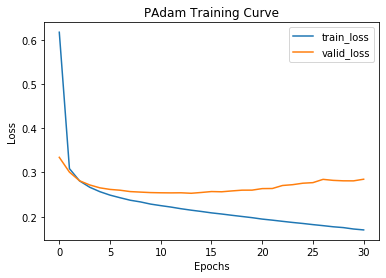

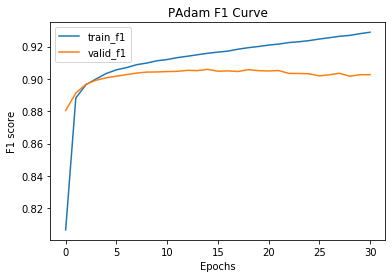

In [14]:
epo=[i for i in range(31)]
plt.title("PAdam Training Curve")
plt.plot(epo, train_loss_lst_padam, label="train_loss")
plt.plot(epo, valid_loss_lst_padam, label="valid_loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.title("PAdam F1 Curve")
plt.plot(epo, train_f1_lst_padam, label="train_f1")
plt.plot(epo, valid_f1_lst_padam, label="valid_f1")

plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()

In [26]:
belif_df=pd.read_parquet('./belif_results30.parquet')
adam_df=pd.read_parquet('./adam_results30.parquet')
padam_df=pd.read_parquet('./padam_results30.parquet')
sgd_df=pd.read_parquet('./sgd_results30.parquet')

In [28]:
full_df = pd.concat([belif_df, adam_df, padam_df, sgd_df])
full_df.to_parquet('./full_df30.parquet')

In [30]:
import pyarrow.parquet as pq
# padam_df.plot(y=['train_loss','valid_loss'])
# adam_df.plot(y=['train_loss','valid_loss'])
# belif_df.plot(y=['train_loss','valid_loss'])
# sgd_df.plot(y=['train_loss','valid_loss'])
# full_df.plot(y=['train_loss','valid_loss'])

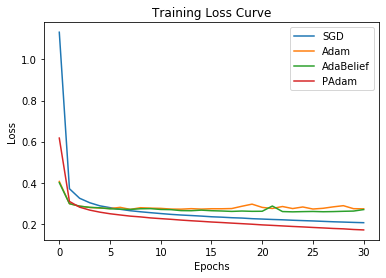

In [31]:
plt.title("Training Loss Curve")
plt.plot(epo, sgd_df['train_loss'], label="SGD")
plt.plot(epo, adam_df['train_loss'], label="Adam")
plt.plot(epo, belif_df['train_loss'], label="AdaBelief")
plt.plot(epo, padam_df['train_loss'], label="PAdam")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


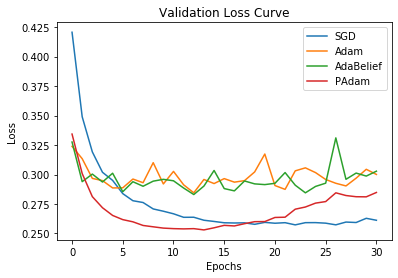

In [32]:
plt.title("Validation Loss Curve")
plt.plot(epo, sgd_df['valid_loss'], label="SGD")
plt.plot(epo, adam_df['valid_loss'], label="Adam")
plt.plot(epo, belif_df['valid_loss'], label="AdaBelief")
plt.plot(epo, padam_df['valid_loss'], label="PAdam")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


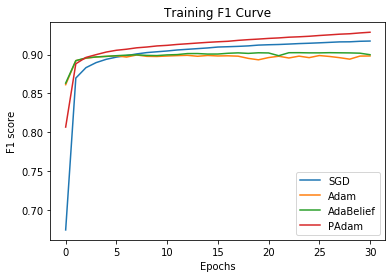

In [33]:
plt.title("Training F1 Curve")
plt.plot(epo, sgd_df['train_f1'], label="SGD")
plt.plot(epo, adam_df['train_f1'], label="Adam")
plt.plot(epo, belif_df['train_f1'], label="AdaBelief")
plt.plot(epo, padam_df['train_f1'], label="PAdam")


plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()

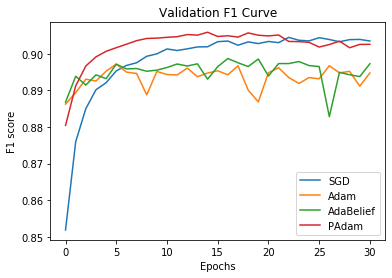

In [34]:

plt.title("Validation F1 Curve")
plt.plot(epo, sgd_df['valid_f1'], label="SGD")
plt.plot(epo, adam_df['valid_f1'], label="Adam")
plt.plot(epo, belif_df['valid_f1'], label="AdaBelief")
plt.plot(epo, padam_df['valid_f1'], label="PAdam")


plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()

In [ ]:

# plt.title("Training Loss Curve")
# plt.plot(epo, sgd_df['train_loss'], label="SGD")
# plt.plot(epo, adam_df['train_loss'], label="Adam")
# plt.plot(epo, belif_df['train_loss'], label="AdaBelief")
# plt.plot(epo, padam_df['train_loss'], label="PAdam")

# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

# plt.title("Validation Loss Curve")
# plt.plot(epo, valid_loss_lst_SGD, label="SGD")
# plt.plot(epo, valid_loss_lst, label="Adam")
# plt.plot(epo, valid_loss_lst_belief, label="AdaBelief")
# plt.plot(epo, valid_loss_lst_padam, label="PAdam")

# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

# plt.title("Training F1 Curve")
# plt.plot(epo, train_f1_lst_SGD, label="SGD")
# plt.plot(epo, train_f1_lst, label="Adam")
# plt.plot(epo, train_f1_lst_belief, label="AdaBelief")
# plt.plot(epo, train_f1_lst_padam, label="PAdam")


# plt.xlabel("Epochs")
# plt.ylabel("F1 score")
# plt.legend()
# plt.show()

# plt.title("Validation F1 Curve")
# plt.plot(epo, valid_f1_lst_SGD, label="SGD")
# plt.plot(epo, valid_f1_lst, label="Adam")
# plt.plot(epo, valid_f1_lst_belief, label="AdaBelief")
# plt.plot(epo, valid_f1_lst_padam, label="PAdam")


# plt.xlabel("Epochs")
# plt.ylabel("F1 score")
# plt.legend()
# plt.show()